In [7]:
#library import

import os 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [8]:
plays = pd.read_csv('plays.csv')
players = pd.read_csv('players.csv')
playerplay = pd.read_csv('player_play.csv')

In [9]:
tracking_data1 = pd.read_csv('tracking_week_1.csv')
tracking_data2 = pd.read_csv('tracking_week_2.csv')
tracking_data3 = pd.read_csv('tracking_week_3.csv')
tracking_data4 = pd.read_csv('tracking_week_4.csv')
tracking_data5 = pd.read_csv('tracking_week_5.csv')
tracking_data6 = pd.read_csv('tracking_week_6.csv')
tracking_data7 = pd.read_csv('tracking_week_7.csv')
tracking_data9 = pd.read_csv('tracking_week_9.csv')

In [10]:
tracking_data = pd.concat([tracking_data1,tracking_data2,tracking_data3,tracking_data4,tracking_data5,tracking_data6,tracking_data7,tracking_data9])
filtered= tracking_data[['gameId','playId','frameId','nflId','displayName','x','y','event']]

In [11]:
playerposition = players[['nflId','position']]

In [12]:
filteredtrack = pd.merge(
    filtered,
    playerposition,
    how='left',
    left_on=['nflId'],
    right_on=['nflId']
)

In [13]:
filteredtrack = filteredtrack[(filteredtrack['position']=="WR") | (filteredtrack['position']=="TE") | (filteredtrack['position']=="RB")]

In [14]:
motionplayers = playerplay[playerplay['motionSinceLineset']==True]

In [15]:
positions = players[['nflId','position']]

In [16]:
motionplayers = pd.merge(
    motionplayers,
    positions,
    how = "left",
    left_on=['nflId'],
    right_on=['nflId']
)

In [17]:
motionplayers = motionplayers[(motionplayers['position']=="WR") | (motionplayers['position']=="TE") | (motionplayers['position']=="RB")]

In [18]:
motiontracking = pd.merge(
    filteredtrack,
    motionplayers[['gameId','playId','nflId','motionSinceLineset','inMotionAtBallSnap']],
    how="inner",
    left_on=['gameId','playId','nflId'],
    right_on=['gameId','playId','nflId']
)

In [19]:
#Filter frame data to reset indices from line_set to ball_snap

def filter_motion_to_snap(group):
    group = group.sort_values(by='frameId').reset_index(drop=True)
    line_set_indices = group[group['event'] == 'line_set'].index
    snap_indices = group[group['event'] == 'ball_snap'].index
    
    filtered_rows = []
    for start_idx in line_set_indices:
        snap_idx = snap_indices[snap_indices > start_idx].min()
        if pd.notna(snap_idx):
            filtered_rows.extend(group.loc[start_idx:snap_idx].index)
    return group.loc[filtered_rows]
filtered_df = motiontracking.groupby(['gameId', 'playId']).apply(filter_motion_to_snap).reset_index(drop=True)

C:\Users\rschw\AppData\Local\Temp\ipykernel_5548\2688534159.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = motiontracking.groupby(['gameId', 'playId']).apply(filter_motion_to_snap).reset_index(drop=True)


In [20]:
filtered_df.head()

,gameId,playId,frameId,nflId,displayName,x,y,event,position,motionSinceLineset,inMotionAtBallSnap
0,2022090800,56,76,42489.0,Stefon Diggs,87.02,27.91,line_set,WR,True,False
1,2022090800,56,77,42489.0,Stefon Diggs,87.04,28.36,NaN,WR,True,False
2,2022090800,56,78,42489.0,Stefon Diggs,87.06,28.82,NaN,WR,True,False
3,2022090800,56,79,42489.0,Stefon Diggs,87.07,29.27,NaN,WR,True,False
4,2022090800,56,80,42489.0,Stefon Diggs,87.09,29.73,NaN,WR,True,False


In [21]:
plays_final = plays[["gameId","playId","absoluteYardlineNumber"]]

In [22]:
#To calculate total distance traveled by each player in motion

def total_distance_multi(df):
    if len(df) < 2:
        return pd.DataFrame(columns=["playId", "nflId", "total_distance"])

    results = []

    # Group by playId and nflId 
    grouped = df.groupby(["playId", "nflId"])
    
    for (playId, nflId), group in grouped:
        temp_distances = []
        start_index = 0  

        # Reset index
        group = group.reset_index(drop=True)

        for i in range(len(group) - 1):
            x_diff = group.iloc[i + 1]["x"] - group.iloc[i]["x"]
            y_diff = group.iloc[i + 1]["y"] - group.iloc[i]["y"]
            temp_distances.append(sqrt(x_diff**2 + y_diff**2))
            
            if group.iloc[i + 1]["event"] == "line_set":
                if temp_distances:
                    results.append({
                        "playId": playId,
                        "nflId": nflId,
                        "total_distance": sum(temp_distances),
                    })
                temp_distances = []  
                start_index = i + 1  

        if temp_distances:
            results.append({
                "playId": playId,
                "nflId": nflId,
                "total_distance": sum(temp_distances),
            })

    return pd.DataFrame(results)


In [23]:
total_distance_final = total_distance_multi(filtered_df)
total_distance_final.head()

,playId,nflId,total_distance
0,54,42369.0,17.395019
1,55,47839.0,4.403501
2,55,47839.0,8.012054
3,56,39975.0,5.643005
4,56,40488.0,4.885120


In [24]:
unique_dist_rows = total_distance_final.drop_duplicates(subset=['nflId', 'playId'])

In [25]:
filtered_df

,gameId,playId,frameId,nflId,displayName,x,y,event,position,motionSinceLineset,inMotionAtBallSnap
0,2022090800,56,76,42489.0,Stefon Diggs,87.02,27.91,line_set,WR,True,False
1,2022090800,56,77,42489.0,Stefon Diggs,87.04,28.36,NaN,WR,True,False
2,2022090800,56,78,42489.0,Stefon Diggs,87.06,28.82,NaN,WR,True,False
3,2022090800,56,79,42489.0,Stefon Diggs,87.07,29.27,NaN,WR,True,False
4,2022090800,56,80,42489.0,Stefon Diggs,87.09,29.73,NaN,WR,True,False
...,...,...,...,...,...,...,...,...,...,...,...
547059,2022110700,3059,122,54604.0,Isaiah Likely,34.98,29.78,NaN,TE,True,False
547060,2022110700,3059,123,54604.0,Isaiah Likely,34.97,29.80,NaN,TE,True,False
547061,2022110700,3059,124,54604.0,Isaiah Likely,34.98,29.82,NaN,TE,True,False
547062,2022110700,3059,125,54604.0,Isaiah Likely,34.98,29.83,NaN,TE,True,False


In [26]:
filtered_df1 = pd.merge(
    filtered_df,
    plays_final[['gameId', 'playId', 'absoluteYardlineNumber']],
    how="inner",
    left_on=['gameId', 'playId'],
    right_on=['gameId', 'playId']
)
filtered_df1

,gameId,playId,frameId,nflId,displayName,x,y,event,position,motionSinceLineset,inMotionAtBallSnap,absoluteYardlineNumber
0,2022090800,56,76,42489.0,Stefon Diggs,87.02,27.91,line_set,WR,True,False,85
1,2022090800,56,77,42489.0,Stefon Diggs,87.04,28.36,NaN,WR,True,False,85
2,2022090800,56,78,42489.0,Stefon Diggs,87.06,28.82,NaN,WR,True,False,85
3,2022090800,56,79,42489.0,Stefon Diggs,87.07,29.27,NaN,WR,True,False,85
4,2022090800,56,80,42489.0,Stefon Diggs,87.09,29.73,NaN,WR,True,False,85
...,...,...,...,...,...,...,...,...,...,...,...,...
547059,2022110700,3059,122,54604.0,Isaiah Likely,34.98,29.78,NaN,TE,True,False,33
547060,2022110700,3059,123,54604.0,Isaiah Likely,34.97,29.80,NaN,TE,True,False,33
547061,2022110700,3059,124,54604.0,Isaiah Likely,34.98,29.82,NaN,TE,True,False,33
547062,2022110700,3059,125,54604.0,Isaiah Likely,34.98,29.83,NaN,TE,True,False,33


In [27]:
motionstats = (
    filtered_df1.groupby(['gameId', 'playId', 'nflId', 'position'])[['x', 'y']]
    .agg(['first', 'last', 'max', 'min'])
    .reset_index()
)

# Flatten the column structure
motionstats.columns = [
    '_'.join(col).strip('_') if isinstance(col, tuple) else col
    for col in motionstats.columns
]

In [28]:
motionstats.head()

,gameId,playId,nflId,position,x_first,x_last,x_max,x_min,y_first,y_last,y_max,y_min
0,2022090800,56,42489.0,WR,87.02,86.24,87.17,86.24,27.91,43.65,43.67,27.91
1,2022090800,80,47857.0,RB,81.74,85.83,85.83,81.72,39.38,31.54,39.41,28.69
2,2022090800,212,47879.0,TE,45.90,46.68,46.68,45.90,23.83,32.83,32.83,23.83
3,2022090800,236,52536.0,WR,37.08,36.79,37.12,36.79,40.09,35.27,40.09,35.27
4,2022090800,299,43399.0,TE,24.11,25.54,25.76,24.09,23.81,18.99,23.81,18.86


In [29]:
#Calculate direction change

y_forward_change = (motionstats['y_last'] > motionstats['y_first']) & (motionstats['y_max'] > (motionstats['y_last'] + 1))
y_backward_change = (motionstats['y_last'] <= motionstats['y_first']) & (motionstats['y_min'] < (motionstats['y_last'] - 1))

x_forward_change = (motionstats['x_last'] > motionstats['x_first']) & (motionstats['x_max'] > (motionstats['x_last'] + 1))
x_backward_change = (motionstats['x_last'] <= motionstats['x_first']) & (motionstats['x_min'] < (motionstats['x_last'] - 1))

motionstats['direction_change'] = (y_forward_change | y_backward_change) | (x_forward_change | x_backward_change)



In [30]:
motionstats = pd.merge(
    motionstats,
    playerplay[['gameId','playId','nflId','inMotionAtBallSnap']],
    how="left",
    left_on=['gameId','playId','nflId'],
    right_on=['gameId','playId','nflId']
)

In [31]:
final_motionstats = pd.merge(
    motionstats,
    unique_dist_rows[['total_distance','playId','nflId']],
    how="left",
    left_on=['playId','nflId'],
    right_on=['playId','nflId']
)

In [32]:
#Edge case: some total distances were high due to data error/misrepresentations, so capped total distance at 100 to make sure clusters are accurate

final_motionstats['total_distance'] = final_motionstats['total_distance'].clip(upper=100)
final_motionstats

,gameId,playId,nflId,position,x_first,x_last,x_max,x_min,y_first,y_last,y_max,y_min,direction_change,inMotionAtBallSnap,total_distance
0,2022090800,56,42489.0,WR,87.02,86.24,87.17,86.24,27.91,43.65,43.67,27.91,False,False,15.935339
1,2022090800,80,47857.0,RB,81.74,85.83,85.83,81.72,39.38,31.54,39.41,28.69,True,True,14.632298
2,2022090800,212,47879.0,TE,45.90,46.68,46.68,45.90,23.83,32.83,32.83,23.83,False,True,9.043568
3,2022090800,236,52536.0,WR,37.08,36.79,37.12,36.79,40.09,35.27,40.09,35.27,False,True,4.990784
4,2022090800,299,43399.0,TE,24.11,25.54,25.76,24.09,23.81,18.99,23.81,18.86,False,False,11.616233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5006,2022110700,2182,33130.0,WR,77.97,80.17,80.17,77.97,21.85,27.69,27.69,21.85,False,True,6.688651
5007,2022110700,2261,43362.0,RB,87.89,88.42,88.42,87.89,25.99,21.37,25.99,21.37,False,False,4.675413
5008,2022110700,2307,43362.0,RB,89.24,90.04,90.04,89.22,28.73,24.25,28.73,24.25,False,False,4.675344
5009,2022110700,2496,44879.0,RB,56.72,56.40,56.94,56.34,23.27,29.17,29.19,23.23,False,False,6.502555


In [33]:
final_df = final_motionstats

In [34]:
final_motionstats = final_motionstats.drop_duplicates(subset=['nflId', 'playId'])

In [35]:
final_df = pd.get_dummies(final_motionstats, columns=['position'], prefix='pos', drop_first=True)
final_df

,gameId,playId,nflId,x_first,x_last,x_max,x_min,y_first,y_last,y_max,y_min,direction_change,inMotionAtBallSnap,total_distance,pos_TE,pos_WR
0,2022090800,56,42489.0,87.02,86.24,87.17,86.24,27.91,43.65,43.67,27.91,False,False,15.935339,False,True
1,2022090800,80,47857.0,81.74,85.83,85.83,81.72,39.38,31.54,39.41,28.69,True,True,14.632298,False,False
2,2022090800,212,47879.0,45.90,46.68,46.68,45.90,23.83,32.83,32.83,23.83,False,True,9.043568,True,False
3,2022090800,236,52536.0,37.08,36.79,37.12,36.79,40.09,35.27,40.09,35.27,False,True,4.990784,False,True
4,2022090800,299,43399.0,24.11,25.54,25.76,24.09,23.81,18.99,23.81,18.86,False,False,11.616233,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5006,2022110700,2182,33130.0,77.97,80.17,80.17,77.97,21.85,27.69,27.69,21.85,False,True,6.688651,False,True
5007,2022110700,2261,43362.0,87.89,88.42,88.42,87.89,25.99,21.37,25.99,21.37,False,False,4.675413,False,False
5008,2022110700,2307,43362.0,89.24,90.04,90.04,89.22,28.73,24.25,28.73,24.25,False,False,4.675344,False,False
5009,2022110700,2496,44879.0,56.72,56.40,56.94,56.34,23.27,29.17,29.19,23.23,False,False,6.502555,False,False


In [36]:
plays_final = plays[["gameId","playId","absoluteYardlineNumber"]]
plays_final

,gameId,playId,absoluteYardlineNumber
0,2022102302,2655,31
1,2022091809,3698,18
2,2022103004,3146,30
3,2022110610,348,33
4,2022102700,2799,37
...,...,...,...
16119,2022110604,1051,79
16120,2022103005,3492,35
16121,2022092502,2337,97
16122,2022091809,719,57


In [37]:
final_df = pd.merge(
    final_df,
    plays_final[['gameId', 'playId', 'absoluteYardlineNumber']],
    how="inner",
    left_on=['gameId', 'playId'],
    right_on=['gameId', 'playId']
)

In [38]:
#Adjusted coordinates to account for absoluteYardlineNumber

def adjust_x_coordinates(row):
 
    adjusted_x_first = abs(row["x_first"] - row["absoluteYardlineNumber"])
    adjusted_x_last = abs(row["x_last"] - row["absoluteYardlineNumber"])
    adjusted_x_max = abs(row["x_max"] - row["absoluteYardlineNumber"])
    adjusted_x_min = abs(row["x_min"] - row["absoluteYardlineNumber"])

   
    return pd.Series([adjusted_x_first, adjusted_x_last, adjusted_x_max, adjusted_x_min])


final_df[['adjusted_x_first', 'adjusted_x_last', 'adjusted_x_max', 'adjusted_x_min']] = final_df.apply(adjust_x_coordinates, axis=1)

final_df[['gameId', 'playId', 'nflId', 'absoluteYardlineNumber', 'x_first', 'x_last', 'x_max', 'x_min',
        'adjusted_x_first', 'adjusted_x_last', 'adjusted_x_max', 'adjusted_x_min',
       'y_first', 'y_last', 'y_max', 'y_min', 'direction_change',
       'inMotionAtBallSnap', 'total_distance', 'pos_TE', 'pos_WR']]



,gameId,playId,nflId,absoluteYardlineNumber,x_first,x_last,x_max,x_min,adjusted_x_first,adjusted_x_last,...,adjusted_x_min,y_first,y_last,y_max,y_min,direction_change,inMotionAtBallSnap,total_distance,pos_TE,pos_WR
0,2022090800,56,42489.0,85,87.02,86.24,87.17,86.24,2.02,1.24,...,1.24,27.91,43.65,43.67,27.91,False,False,15.935339,False,True
1,2022090800,80,47857.0,79,81.74,85.83,85.83,81.72,2.74,6.83,...,2.72,39.38,31.54,39.41,28.69,True,True,14.632298,False,False
2,2022090800,212,47879.0,44,45.90,46.68,46.68,45.90,1.90,2.68,...,1.90,23.83,32.83,32.83,23.83,False,True,9.043568,True,False
3,2022090800,236,52536.0,36,37.08,36.79,37.12,36.79,1.08,0.79,...,0.79,40.09,35.27,40.09,35.27,False,True,4.990784,False,True
4,2022090800,299,43399.0,27,24.11,25.54,25.76,24.09,2.89,1.46,...,2.91,23.81,18.99,23.81,18.86,False,False,11.616233,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992,2022110700,2182,33130.0,83,77.97,80.17,80.17,77.97,5.03,2.83,...,5.03,21.85,27.69,27.69,21.85,False,True,6.688651,False,True
4993,2022110700,2261,43362.0,94,87.89,88.42,88.42,87.89,6.11,5.58,...,6.11,25.99,21.37,25.99,21.37,False,False,4.675413,False,False
4994,2022110700,2307,43362.0,96,89.24,90.04,90.04,89.22,6.76,5.96,...,6.78,28.73,24.25,28.73,24.25,False,False,4.675344,False,False
4995,2022110700,2496,44879.0,51,56.72,56.40,56.94,56.34,5.72,5.40,...,5.34,23.27,29.17,29.19,23.23,False,False,6.502555,False,False


In [39]:
final_df

,gameId,playId,nflId,x_first,x_last,x_max,x_min,y_first,y_last,y_max,...,direction_change,inMotionAtBallSnap,total_distance,pos_TE,pos_WR,absoluteYardlineNumber,adjusted_x_first,adjusted_x_last,adjusted_x_max,adjusted_x_min
0,2022090800,56,42489.0,87.02,86.24,87.17,86.24,27.91,43.65,43.67,...,False,False,15.935339,False,True,85,2.02,1.24,2.17,1.24
1,2022090800,80,47857.0,81.74,85.83,85.83,81.72,39.38,31.54,39.41,...,True,True,14.632298,False,False,79,2.74,6.83,6.83,2.72
2,2022090800,212,47879.0,45.90,46.68,46.68,45.90,23.83,32.83,32.83,...,False,True,9.043568,True,False,44,1.90,2.68,2.68,1.90
3,2022090800,236,52536.0,37.08,36.79,37.12,36.79,40.09,35.27,40.09,...,False,True,4.990784,False,True,36,1.08,0.79,1.12,0.79
4,2022090800,299,43399.0,24.11,25.54,25.76,24.09,23.81,18.99,23.81,...,False,False,11.616233,True,False,27,2.89,1.46,1.24,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992,2022110700,2182,33130.0,77.97,80.17,80.17,77.97,21.85,27.69,27.69,...,False,True,6.688651,False,True,83,5.03,2.83,2.83,5.03
4993,2022110700,2261,43362.0,87.89,88.42,88.42,87.89,25.99,21.37,25.99,...,False,False,4.675413,False,False,94,6.11,5.58,5.58,6.11
4994,2022110700,2307,43362.0,89.24,90.04,90.04,89.22,28.73,24.25,28.73,...,False,False,4.675344,False,False,96,6.76,5.96,5.96,6.78
4995,2022110700,2496,44879.0,56.72,56.40,56.94,56.34,23.27,29.17,29.19,...,False,False,6.502555,False,False,51,5.72,5.40,5.94,5.34


In [40]:
#Edge Case: Some players moved slightly which counted as "motion", only counted legitimate motion by dropping all movements below a total distance of 2

final_df = final_df[final_df["total_distance"] >= 2]
final_df.head()

,gameId,playId,nflId,x_first,x_last,x_max,x_min,y_first,y_last,y_max,...,direction_change,inMotionAtBallSnap,total_distance,pos_TE,pos_WR,absoluteYardlineNumber,adjusted_x_first,adjusted_x_last,adjusted_x_max,adjusted_x_min
0,2022090800,56,42489.0,87.02,86.24,87.17,86.24,27.91,43.65,43.67,...,False,False,15.935339,False,True,85,2.02,1.24,2.17,1.24
1,2022090800,80,47857.0,81.74,85.83,85.83,81.72,39.38,31.54,39.41,...,True,True,14.632298,False,False,79,2.74,6.83,6.83,2.72
2,2022090800,212,47879.0,45.90,46.68,46.68,45.90,23.83,32.83,32.83,...,False,True,9.043568,True,False,44,1.90,2.68,2.68,1.90
3,2022090800,236,52536.0,37.08,36.79,37.12,36.79,40.09,35.27,40.09,...,False,True,4.990784,False,True,36,1.08,0.79,1.12,0.79
4,2022090800,299,43399.0,24.11,25.54,25.76,24.09,23.81,18.99,23.81,...,False,False,11.616233,True,False,27,2.89,1.46,1.24,2.91


In [41]:
final_df_sorted = final_df.sort_values(by="total_distance", ascending=True)
final_df_sorted

,gameId,playId,nflId,x_first,x_last,x_max,x_min,y_first,y_last,y_max,...,direction_change,inMotionAtBallSnap,total_distance,pos_TE,pos_WR,absoluteYardlineNumber,adjusted_x_first,adjusted_x_last,adjusted_x_max,adjusted_x_min
1511,2022091801,1412,46279.0,65.23,66.03,66.03,65.23,14.62,16.46,16.46,...,False,True,2.010952,False,True,63,2.23,3.03,3.03,2.23
223,2022091101,2951,43808.0,79.02,78.94,79.12,78.77,9.34,9.35,9.39,...,False,True,2.012932,False,True,77,2.02,1.94,2.12,1.77
4815,2022110605,2985,45185.0,56.96,57.47,57.47,56.95,15.27,16.83,16.83,...,False,True,2.017515,False,True,55,1.96,2.47,2.47,1.95
4278,2022102303,3352,52425.0,83.52,83.19,83.55,83.19,37.58,35.87,37.61,...,False,True,2.031149,False,True,86,2.48,2.81,2.45,2.81
4991,2022110700,1577,43362.0,23.71,24.00,24.10,23.68,29.67,30.98,31.17,...,False,False,2.034798,False,False,22,1.71,2.00,2.10,1.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,2022091106,130,42357.0,55.93,55.84,56.05,55.53,43.40,16.83,43.51,...,False,False,100.000000,False,True,59,3.07,3.16,2.95,3.47
2776,2022100202,366,53855.0,34.25,34.99,36.53,34.25,45.54,36.53,45.61,...,True,False,100.000000,True,False,33,1.25,1.99,3.53,1.25
807,2022091108,705,42589.0,101.03,101.96,103.79,101.03,34.26,21.93,34.26,...,True,False,100.000000,True,False,100,1.03,1.96,3.79,1.03
3689,2022101600,1090,48374.0,36.00,36.90,36.92,34.19,38.42,20.44,38.48,...,False,False,100.000000,False,True,38,2.00,1.10,1.08,3.81


In [42]:
# Ensure specific columns are integers

final_df['direction_change'] = final_df['direction_change'].astype(int)
final_df['inMotionAtBallSnap'] = final_df['inMotionAtBallSnap'].astype(int)

# Define the columns 

clustering_columns = [
    'adjusted_x_first', 'adjusted_x_last', 'adjusted_x_max', 'adjusted_x_min',
    'y_first', 'y_last', 'y_max', 'y_min', 'direction_change',
    'inMotionAtBallSnap', 'total_distance', 'pos_TE', 'pos_WR'
]

# Extract clustering data and IDs separately

final_final_df = final_df[clustering_columns]
id_columns = final_df[['nflId', 'gameId', 'playId']]


final_final_df = final_final_df[final_final_df["total_distance"] != 100]
id_columns = id_columns.loc[final_final_df.index]  # Align IDs with filtered data

# Scale data 

scaler = StandardScaler()
motion_scaled = scaler.fit_transform(final_final_df)


kmeans = KMeans(n_clusters=7, random_state=0)
final_final_df['cluster'] = kmeans.fit_predict(motion_scaled)


final_final_df = pd.concat([id_columns.reset_index(drop=True), final_final_df.reset_index(drop=True)], axis=1)
final_final_df


C:\Users\rschw\AppData\Local\Temp\ipykernel_5548\2022850468.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['direction_change'] = final_df['direction_change'].astype(int)
C:\Users\rschw\AppData\Local\Temp\ipykernel_5548\2022850468.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['inMotionAtBallSnap'] = final_df['inMotionAtBallSnap'].astype(int)


,nflId,gameId,playId,adjusted_x_first,adjusted_x_last,adjusted_x_max,adjusted_x_min,y_first,y_last,y_max,y_min,direction_change,inMotionAtBallSnap,total_distance,pos_TE,pos_WR,cluster
0,42489.0,2022090800,56,2.02,1.24,2.17,1.24,27.91,43.65,43.67,27.91,0,0,15.935339,False,True,5
1,47857.0,2022090800,80,2.74,6.83,6.83,2.72,39.38,31.54,39.41,28.69,1,1,14.632298,False,False,0
2,47879.0,2022090800,212,1.90,2.68,2.68,1.90,23.83,32.83,32.83,23.83,0,1,9.043568,True,False,1
3,52536.0,2022090800,236,1.08,0.79,1.12,0.79,40.09,35.27,40.09,35.27,0,1,4.990784,False,True,3
4,43399.0,2022090800,299,2.89,1.46,1.24,2.91,23.81,18.99,23.81,18.86,0,0,11.616233,True,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4630,33130.0,2022110700,2182,5.03,2.83,2.83,5.03,21.85,27.69,27.69,21.85,0,1,6.688651,False,True,6
4631,43362.0,2022110700,2261,6.11,5.58,5.58,6.11,25.99,21.37,25.99,21.37,0,0,4.675413,False,False,0
4632,43362.0,2022110700,2307,6.76,5.96,5.96,6.78,28.73,24.25,28.73,24.25,0,0,4.675344,False,False,0
4633,44879.0,2022110700,2496,5.72,5.40,5.94,5.34,23.27,29.17,29.19,23.23,0,0,6.502555,False,False,0


In [43]:
cluster_means = final_final_df.groupby('cluster').agg(
    x_first_mean=('adjusted_x_first', 'mean'),
    x_last_mean=('adjusted_x_last', 'mean'),
    y_first_mean=('y_first', 'mean'),
    y_last_mean=('y_last', 'mean'),
    direction_change_mean=('direction_change', 'mean'),
    move_at_snap_mean=('inMotionAtBallSnap', 'mean'),
    total_distance_mean=('total_distance', 'mean'),
    te = ('pos_TE','mean'),
    wr = ('pos_WR','mean'),
)

cluster_means


,x_first_mean,x_last_mean,y_first_mean,y_last_mean,direction_change_mean,move_at_snap_mean,total_distance_mean,te,wr
cluster,,,,,,,,,
0,5.416654,5.664994,26.545610,26.608566,0.116981,0.276730,8.724442,0.008805,0.045283
1,2.325797,2.130797,32.718156,31.107392,0.048173,0.297342,13.044225,1.000000,0.000000
2,2.438560,2.420046,27.706641,24.182492,0.227554,0.413313,26.617944,0.020124,0.916409
3,2.280774,3.000919,35.908823,31.757387,0.020968,0.993548,9.609204,0.000000,0.891935
4,2.440980,2.214284,21.298844,23.414108,0.087940,0.300251,12.487391,0.969849,0.000000
5,2.742005,2.155035,32.774149,37.131189,0.048951,0.002331,14.121838,0.000000,0.682984
6,2.333681,2.815154,16.112865,20.640161,0.020080,0.651941,9.508971,0.001339,0.836680


In [44]:
final_final_df["new_position"] = final_final_df.apply(
    lambda row: 0 if row["pos_WR"] == 1 else (1 if row["pos_TE"] == 1 else 2),
    axis=1  
)

final_final_df.head()

,nflId,gameId,playId,adjusted_x_first,adjusted_x_last,adjusted_x_max,adjusted_x_min,y_first,y_last,y_max,y_min,direction_change,inMotionAtBallSnap,total_distance,pos_TE,pos_WR,cluster,new_position
0,42489.0,2022090800,56,2.02,1.24,2.17,1.24,27.91,43.65,43.67,27.91,0,0,15.935339,False,True,5,0
1,47857.0,2022090800,80,2.74,6.83,6.83,2.72,39.38,31.54,39.41,28.69,1,1,14.632298,False,False,0,2
2,47879.0,2022090800,212,1.90,2.68,2.68,1.90,23.83,32.83,32.83,23.83,0,1,9.043568,True,False,1,1
3,52536.0,2022090800,236,1.08,0.79,1.12,0.79,40.09,35.27,40.09,35.27,0,1,4.990784,False,True,3,0
4,43399.0,2022090800,299,2.89,1.46,1.24,2.91,23.81,18.99,23.81,18.86,0,0,11.616233,True,False,4,1


In [45]:
#Export final file

clusters_final = final_final_df[['nflId', 'gameId', 'playId', 'cluster']]
clusters_final.to_csv("clusters.csv")

In [46]:
cluster_means

,x_first_mean,x_last_mean,y_first_mean,y_last_mean,direction_change_mean,move_at_snap_mean,total_distance_mean,te,wr
cluster,,,,,,,,,
0,5.416654,5.664994,26.545610,26.608566,0.116981,0.276730,8.724442,0.008805,0.045283
1,2.325797,2.130797,32.718156,31.107392,0.048173,0.297342,13.044225,1.000000,0.000000
2,2.438560,2.420046,27.706641,24.182492,0.227554,0.413313,26.617944,0.020124,0.916409
3,2.280774,3.000919,35.908823,31.757387,0.020968,0.993548,9.609204,0.000000,0.891935
4,2.440980,2.214284,21.298844,23.414108,0.087940,0.300251,12.487391,0.969849,0.000000
5,2.742005,2.155035,32.774149,37.131189,0.048951,0.002331,14.121838,0.000000,0.682984
6,2.333681,2.815154,16.112865,20.640161,0.020080,0.651941,9.508971,0.001339,0.836680


In [47]:
pairplot_columns = ['y_first', 'y_last', 'total_distance', 'direction_change', 'cluster','new_position']

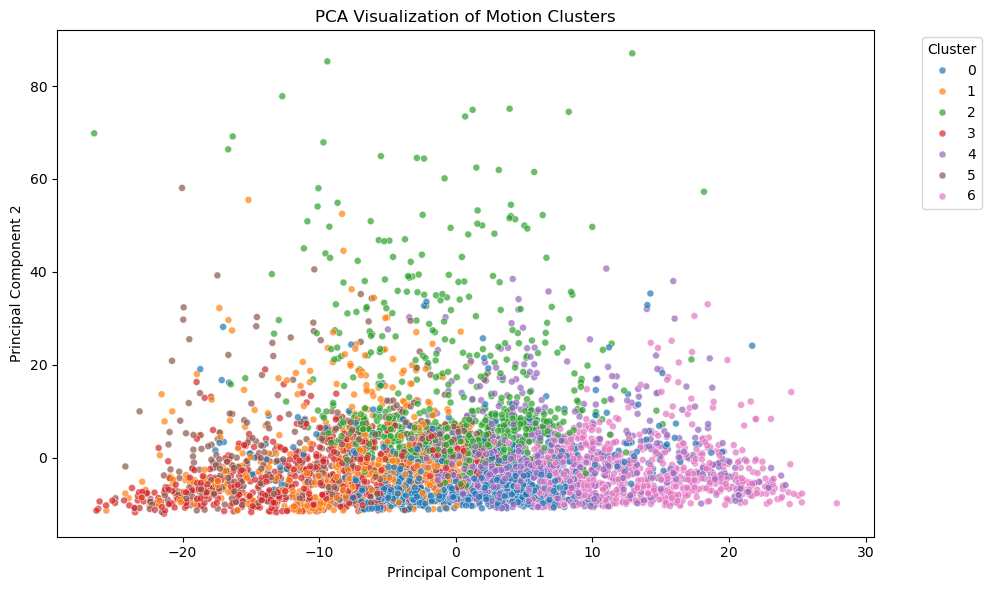

In [48]:
# Perform PCA on the numerical columns

pca = PCA(n_components=2)  # Reduce to 2 dimensions 
pca_results = pca.fit_transform(final_final_df[pairplot_columns])


final_final_df['PCA_1'] = pca_results[:, 0]
final_final_df['PCA_2'] = pca_results[:, 1]

# Plot results

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=final_final_df,
    x='PCA_2',
    y='PCA_1',
    hue='cluster',
    palette='tab10',
    s=25,
    alpha=0.7
)

plt.title("PCA Visualization of Motion Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


plt.savefig("pca_visualization.png", dpi=300, bbox_inches='tight')  
plt.show()


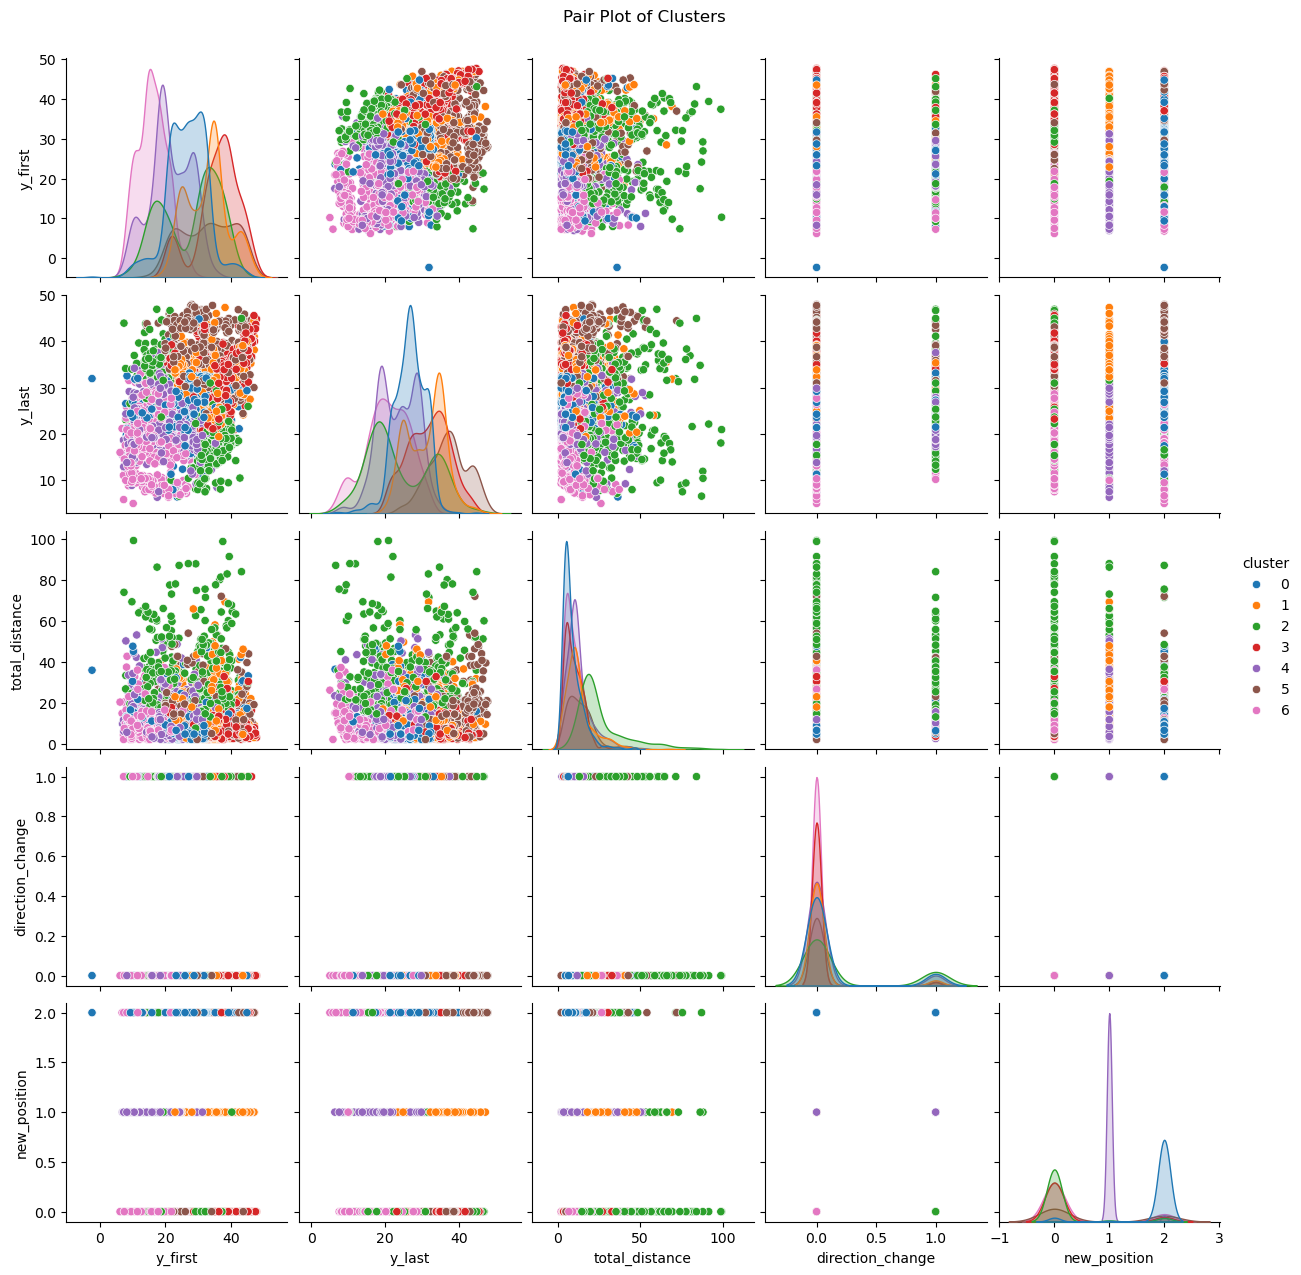

In [49]:
#Another visualization we may include

sns.pairplot(final_final_df[pairplot_columns], hue='cluster', palette='tab10', diag_kind='kde')
plt.suptitle("Pair Plot of Clusters", y=1.02)
plt.show()